## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [ ]:
# 구글 드라이브 마운트, Colab을 이용하지 않는다면 패스해도 됩니다.
# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)
# drive.mount('/content/drive')

In [ ]:
# 구글 드라이브에 업로드된 대회 데이터를 압축 해제하고 로컬에 저장합니다.
# !wget https://aistages-api-public-prod.s3.amazonaws.com/app/Competitions/000321/data/data.tar.gz
# !tar -xvf data.tar.gz > /dev/null

In [ ]:
# !wget https://aistages-api-public-prod.s3.amazonaws.com/app/Competitions/000321/data/code.tar.gz
# !tar -xvf code.tar.gz > /dev/null

In [ ]:
# 필요한 라이브러리를 설치합니다.
# !pip install implicit

## 2. Import Library & Load Dataset
* 학습에 필요한 라이브러리를 로드합니다.

In [ ]:
import pandas as pd
import numpy as np
from scipy import sparse
from implicit.als import AlternatingLeastSquares
from tqdm import tqdm

In [25]:
# 데이터를 로드합니다.
# colab
# df = pd.read_parquet('/content/data/train.parquet')

# local
df = pd.read_parquet('../data/train.parquet')

In [26]:
df.head()

,user_id,item_id,user_session,event_time,category_code,brand,price,event_type
0,0b517454-e7c3-44ec-8c39-a68ef9c0ec60,18c11cbb-a18d-4a9e-bdea-6abd3f7d3c04,ad97f19a-f5fb-41ea-a7b2-52c21fb37ab2,2019-11-16 16:31:26 UTC,apparel.shoes,kapika,72.05,view
1,215eeee5-f9c5-4213-8641-7561dbdad1b9,47c5a6da-32d0-4a29-8b51-57304f476ded,6058b45b-bdb9-4d6c-b300-42dcb1cb8280,2019-11-04 18:59:50 UTC,apparel.shoes,respect,82.63,view
2,a25bf14a-49ac-49bb-87de-ee6b300f0cc4,a6d915c6-2bb7-4393-a556-c327723d3666,28a8b8e3-b374-435d-9d5d-b96058ecb75b,2019-11-26 09:01:47 UTC,apparel.tshirt,goodloot,24.43,view
3,09ee8591-25e0-4bb4-ae24-c48ed4212e3c,0fd4da5d-989c-4a75-9ace-2b108f834c8c,f2972db7-9916-4a58-b6f9-c76afde6245e,2019-11-15 16:05:34 UTC,apparel.shoes,baden,70.79,view
4,7acf7c81-69f6-4aa8-b19f-8e85aeaffc28,d52d1c91-5534-4de4-aaf1-318e932e10e7,7d46d970-b40e-4a2f-81a7-65bf23aa0aae,2019-11-16 13:14:09 UTC,apparel.shoes,rooman,53.80,view


## EDA & 데이터 전처리 (Data Preprocessing)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
# 결측치 확인
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 8350311 entries, 0 to 8350310
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   user_id        8350311 non-null  object 
 1   item_id        8350311 non-null  object 
 2   user_session   8350311 non-null  object 
 3   event_time     8350311 non-null  object 
 4   category_code  8350311 non-null  object 
 5   brand          8350311 non-null  object 
 6   price          8350311 non-null  float64
 7   event_type     8350311 non-null  object 
dtypes: float64(1), object(7)
memory usage: 573.4+ MB


In [10]:
# 중복 데이터 확인
print('중복 데이터 갯수:', df.duplicated().sum())
df.loc[df.duplicated(keep=False)]

중복 데이터 갯수: 18


,user_id,item_id,user_session,event_time,category_code,brand,price,event_type
4236094,c9bb5620-6a79-4a5d-8b0c-38c21b64d683,4e18920d-0ed8-4bff-9475-249623d2f98a,bdab9efe-8167-4d2e-ac58-3efc64022497,2020-01-31 07:28:37 UTC,apparel.shoes,hoco,17.99,view
4236095,c9bb5620-6a79-4a5d-8b0c-38c21b64d683,4e18920d-0ed8-4bff-9475-249623d2f98a,bdab9efe-8167-4d2e-ac58-3efc64022497,2020-01-31 07:28:37 UTC,apparel.shoes,hoco,17.99,view
4273937,7508dde6-e395-48bd-ae69-e32b31687ee5,2e0d2baf-84f8-4609-8411-40106770595a,01353707-a700-4fc2-a0f5-2dd284ea8d8d,2020-01-31 16:21:36 UTC,apparel.shoes,xiaomi,26.72,cart
4273938,7508dde6-e395-48bd-ae69-e32b31687ee5,2e0d2baf-84f8-4609-8411-40106770595a,01353707-a700-4fc2-a0f5-2dd284ea8d8d,2020-01-31 16:21:36 UTC,apparel.shoes,xiaomi,26.72,cart
4436290,5d6675ab-63f1-4568-840f-98cf8afcac24,a36397b5-301d-4fd2-8e23-feedc1573193,0fd9b0ba-4e2f-4bac-8972-e17095c2ceed,2020-01-30 16:30:03 UTC,apparel.scarf,welly,5.92,cart
4436292,5d6675ab-63f1-4568-840f-98cf8afcac24,a36397b5-301d-4fd2-8e23-feedc1573193,0fd9b0ba-4e2f-4bac-8972-e17095c2ceed,2020-01-30 16:30:03 UTC,apparel.scarf,welly,5.92,cart
4697982,31f1caf8-c4c1-4247-a37a-5a6cef217ea2,c2d911d7-9cb5-4d05-9116-a52a4a4977f1,4872e0f4-10c8-46ec-b7d1-f3bf12132fc9,2020-01-31 02:46:38 UTC,apparel.shoes,xiaomi,21.18,cart
4697983,31f1caf8-c4c1-4247-a37a-5a6cef217ea2,c2d911d7-9cb5-4d05-9116-a52a4a4977f1,4872e0f4-10c8-46ec-b7d1-f3bf12132fc9,2020-01-31 02:46:38 UTC,apparel.shoes,xiaomi,21.18,cart
5507597,6544a4bf-0a87-4852-8be7-6c40420d2cff,a3014d1a-4181-4890-9c93-169822bc0618,b89d0092-a3b1-41cf-bbeb-8fefc7e4040a,2020-01-31 06:08:13 UTC,apparel.shoes,moser,80.00,cart
5507598,6544a4bf-0a87-4852-8be7-6c40420d2cff,a3014d1a-4181-4890-9c93-169822bc0618,b89d0092-a3b1-41cf-bbeb-8fefc7e4040a,2020-01-31 06:08:13 UTC,apparel.shoes,moser,80.00,cart


*   중복 데이터 처리 (Duplicated Data Handling)

In [27]:
# 중복 데이터 제거
df.drop_duplicates(inplace=True, ignore_index=True)
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8350293 entries, 0 to 8350292
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   user_id        8350293 non-null  object 
 1   item_id        8350293 non-null  object 
 2   user_session   8350293 non-null  object 
 3   event_time     8350293 non-null  object 
 4   category_code  8350293 non-null  object 
 5   brand          8350293 non-null  object 
 6   price          8350293 non-null  float64
 7   event_type     8350293 non-null  object 
dtypes: float64(1), object(7)
memory usage: 509.7+ MB


In [6]:
# 기술 통계값 확인
df.describe(include='all')

,user_id,item_id,user_session,event_time,category_code,brand,price,event_type
count,8350293,8350293,8350293,8350293,8350293,8350293,8.350293e+06,8350293
unique,638257,29502,2889552,5063343,24,1859,NaN,3
top,6034a8f4-0f6a-4af4-8e8c-7fff6649058b,2e0d2baf-84f8-4609-8411-40106770595a,f0bdf5e5-4816-4b0e-a385-163dee41e1d5,2020-01-31 11:58:39 UTC,apparel.shoes,respect,NaN,view
freq,37207,143758,1674,40,2960533,723402,NaN,8331867
mean,NaN,NaN,NaN,NaN,NaN,NaN,1.509160e+02,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,2.292734e+02,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,7.700000e-01,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,4.371000e+01,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,7.902000e+01,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,1.439400e+02,NaN


#### category_code 세분화
    >   대분류 : apparel
    >   소분류 : 중분류가 shoes 중 일부 데이터에 존재
- category_code에서 apparel 제거 처리

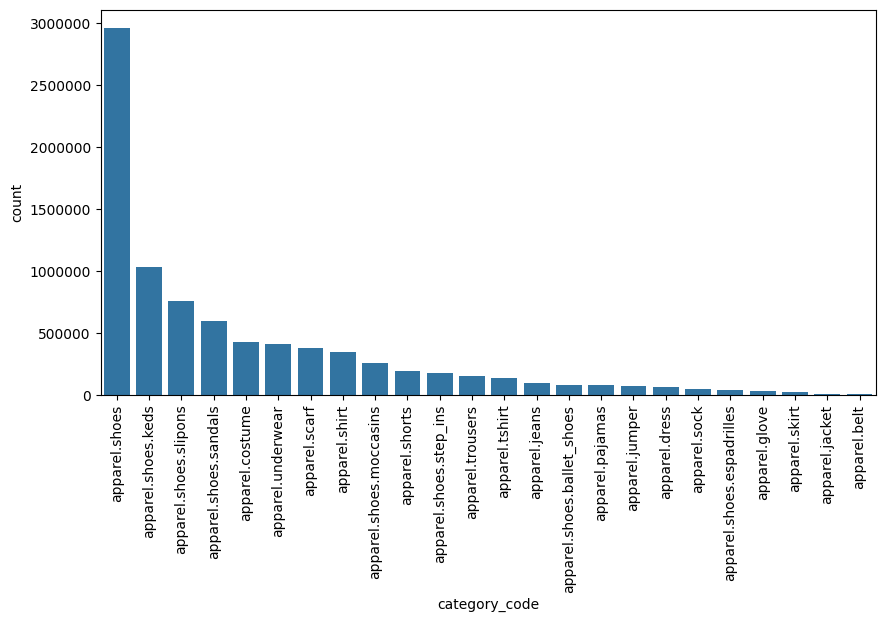

In [64]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='category_code', order=df['category_code'].value_counts().index)
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.xticks(rotation=90)
plt.show()

In [23]:
df['category_code'].apply(lambda x: len(x.split('.'))).value_counts()

category_code
2    5413584
3    2936709
Name: count, dtype: int64

In [5]:
item_df = df.loc[:, ['item_id', 'category_code', 'brand', 'price']].copy()
item_df[['field_category', 'group_category', 'individual_category']] = item_df['category_code'].str.split('.', expand=True)
item_df.head()

,item_id,category_code,brand,price,field_category,group_category,individual_category
0,18c11cbb-a18d-4a9e-bdea-6abd3f7d3c04,apparel.shoes,kapika,72.05,apparel,shoes,None
1,47c5a6da-32d0-4a29-8b51-57304f476ded,apparel.shoes,respect,82.63,apparel,shoes,None
2,a6d915c6-2bb7-4393-a556-c327723d3666,apparel.tshirt,goodloot,24.43,apparel,tshirt,None
3,0fd4da5d-989c-4a75-9ace-2b108f834c8c,apparel.shoes,baden,70.79,apparel,shoes,None
4,d52d1c91-5534-4de4-aaf1-318e932e10e7,apparel.shoes,rooman,53.80,apparel,shoes,None


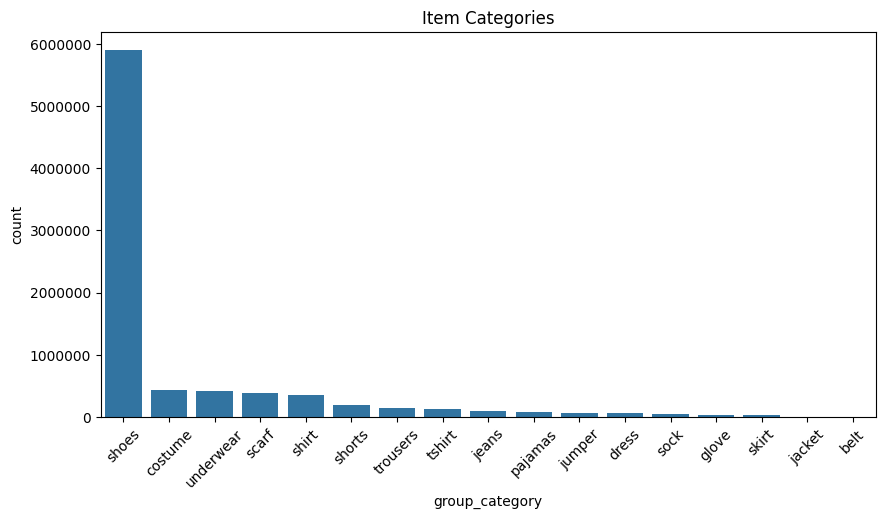

In [60]:
plt.figure(figsize=(10, 5))
sns.countplot(data=item_df, x='group_category', order=item_df['group_category'].value_counts().index)
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.xticks(rotation=45)
plt.title('Item Categories')
plt.show()

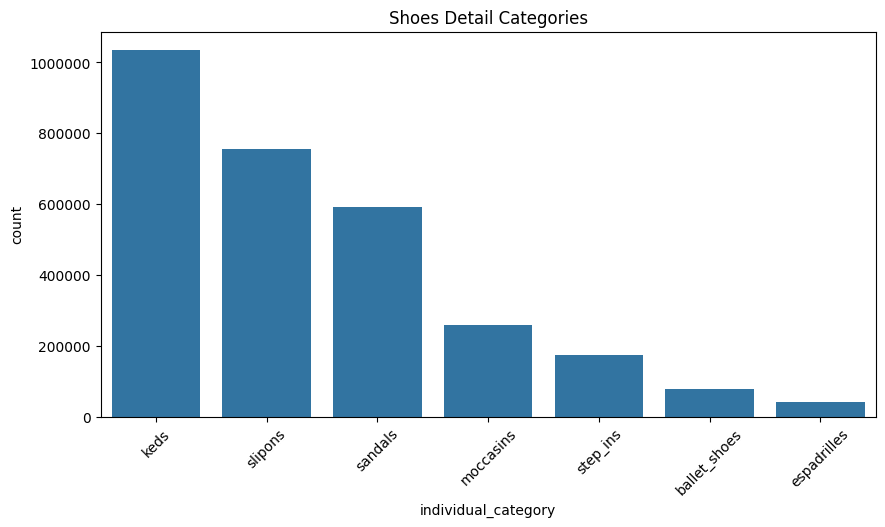

In [61]:
plt.figure(figsize=(10, 5))
sns.countplot(data=item_df, x='individual_category', order=item_df['individual_category'].value_counts().index)
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.xticks(rotation=45)
plt.title('Shoes Detail Categories')
plt.show()

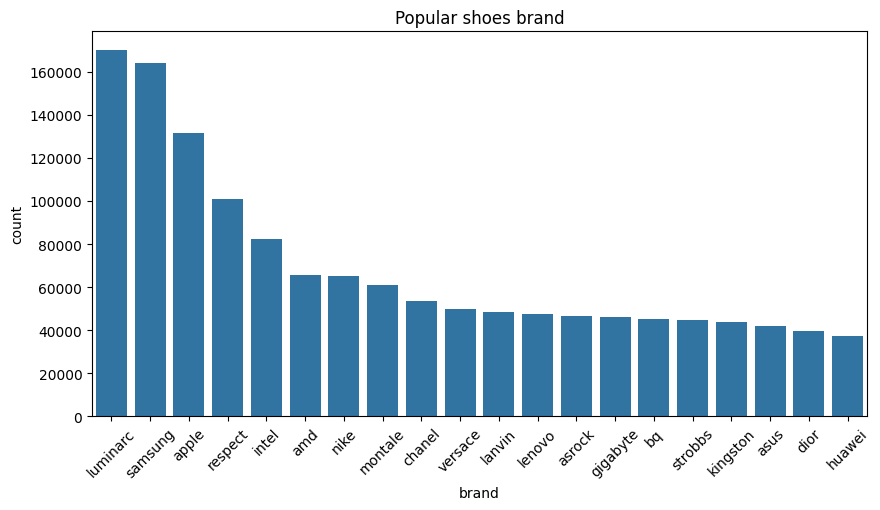

In [71]:
temp_df = item_df.dropna()

plt.figure(figsize=(10, 5))
sns.countplot(data=temp_df, x='brand', order=temp_df['brand'].value_counts()[:20].index)
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.xticks(rotation=45)
plt.title('Popular shoes brand')
plt.show()

del temp_df

In [81]:
del item_df

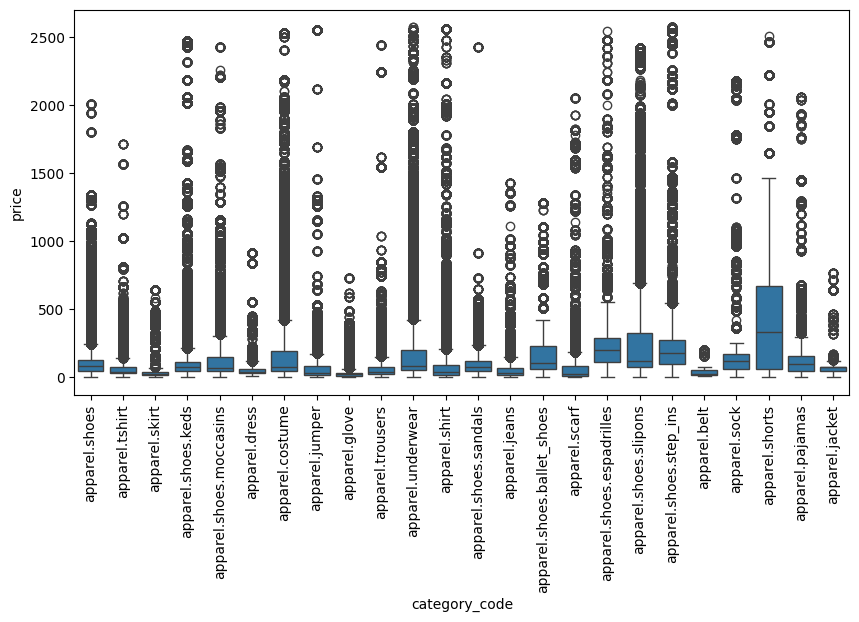

In [ ]:
# 상품 카테고리 별 가격 분포
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='category_code', y='price')
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.xticks(rotation=90)
plt.show()

#### event_time 구성 데이터 분석

> 사용자 상호작용 일자에 대한 이상치 존재 (해당 일자에 무슨 이벤트가 있었나?)

> 오후에 주문이 많은데... 시간대를 범주형 변수로 변환해야할까? 

> 주말 (일요일, 토요일) 주문 많음

> 공휴일 여부
  - https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store/discussion/193218 

In [ ]:
time_df = df[['event_time']].copy()
time_df['event_time'] = pd.to_datetime(time_df['event_time'], format='%Y-%m-%d %H:%M:%S %Z')
time_df = time_df.sort_values('event_time', ascending=True, ignore_index=True)

In [32]:
time_df.head()

,event_time
0,2019-11-01 00:00:17+00:00
1,2019-11-01 00:01:21+00:00
2,2019-11-01 00:01:41+00:00
3,2019-11-01 00:02:44+00:00
4,2019-11-01 00:04:05+00:00


In [63]:
time_df['event_date'] = time_df['event_time'].dt.date
time_df['event_hour'] = time_df['event_time'].dt.hour
# 요일 - 월요일(0), 화요일(1), 수요일(2), 목요일(3), 금요일(4), 토요일(5), 일요일(6)
time_df['event_dayofweek'] = time_df['event_time'].dt.dayofweek

dict_str_dayofweek = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
time_df['event_dayofweek'] = time_df['event_dayofweek'].map(dict_str_dayofweek)
time_df.head()

,event_time,event_date,event_hour,event_dayofweek
0,2019-11-01 00:00:17+00:00,2019-11-01,0,Friday
1,2019-11-01 00:01:21+00:00,2019-11-01,0,Friday
2,2019-11-01 00:01:41+00:00,2019-11-01,0,Friday
3,2019-11-01 00:02:44+00:00,2019-11-01,0,Friday
4,2019-11-01 00:04:05+00:00,2019-11-01,0,Friday


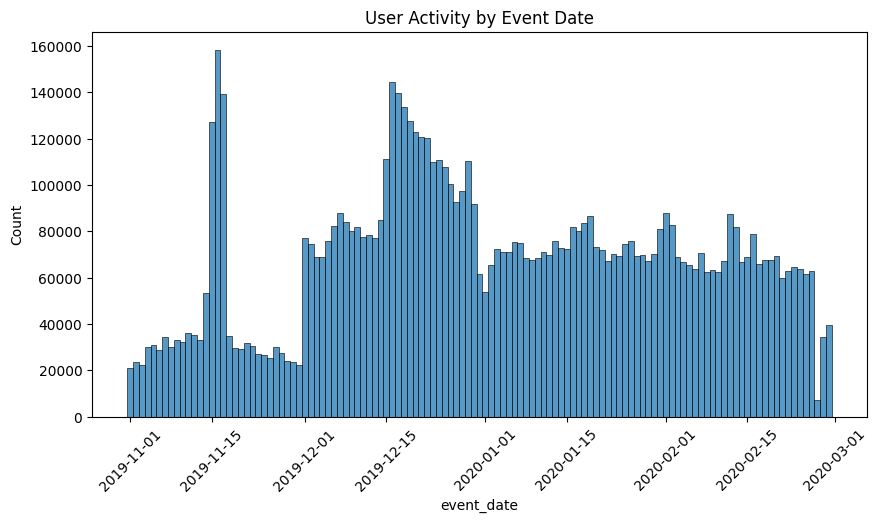

In [68]:
plt.figure(figsize=(10, 5))
sns.histplot(data=time_df, x='event_date')
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.xticks(rotation=45)
plt.title('User Activity by Event Date')
plt.show()

In [28]:
time_df['event_date'].value_counts()

event_date
2019-11-16    158154
2019-12-16    144577
2019-12-17    139769
2019-11-17    139098
2019-12-18    133546
               ...  
2019-11-29     23687
2019-11-30     22457
2019-11-03     22256
2019-11-01     21063
2020-02-27      7201
Name: count, Length: 121, dtype: int64

<Axes: >

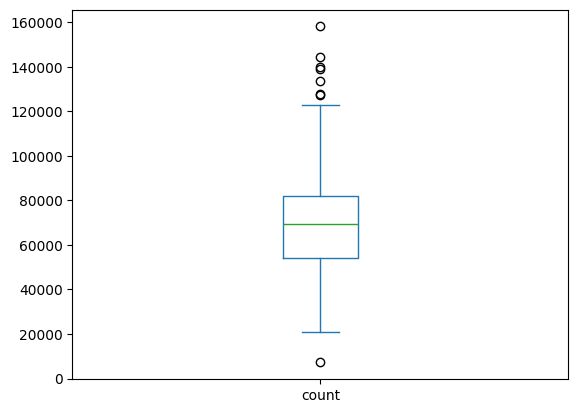

In [36]:
time_df['event_date'].value_counts().plot(kind='box')

In [79]:
event_date_count_df = time_df['event_date'].value_counts().reset_index()
event_date_count_df.head()

,event_date,count
0,2019-11-16,158154
1,2019-12-16,144577
2,2019-12-17,139769
3,2019-11-17,139098
4,2019-12-18,133546


In [80]:
event_date_count_df.describe()

,count
count,121.000000
mean,69010.685950
std,29872.027067
min,7201.000000
25%,54057.000000
50%,69258.000000
75%,81899.000000
max,158154.000000


In [81]:
event_date_Q3 = event_date_count_df['count'].quantile(q=0.75)
event_date_Q1 = event_date_count_df['count'].quantile(q=0.25)
event_date_IQR = event_date_Q3-event_date_Q1
event_date_High = event_date_Q3 + 1.5 * event_date_IQR
event_date_Low = event_date_Q1 - 1.5 * event_date_IQR
print('Event date IQR:', event_date_IQR)
print('Event date High:', event_date_High)
print('Event date Low:', event_date_Low)

Event date IQR: 27842.0
Event date High: 123662.0
Event date Low: 12294.0


In [91]:
# 사용자 상호작용 일자에 대한 이상치
user_interaction_date_outlier = event_date_count_df.loc[(event_date_count_df['count'] > event_date_High) | (event_date_count_df['count'] < event_date_Low), 'event_date'].tolist()
time_df.loc[time_df['event_date'].isin(user_interaction_date_outlier), ['event_date', 'event_dayofweek']].drop_duplicates()

,event_date,event_dayofweek
443959,2019-11-15,Friday
571182,2019-11-16,Saturday
729336,2019-11-17,Sunday
2441712,2019-12-16,Monday
2586289,2019-12-17,Tuesday
2726058,2019-12-18,Wednesday
2859604,2019-12-19,Thursday
8269086,2020-02-27,Thursday


- 2019-11-15, 2019-11-16, 2019-11-17 근처:
    - UAE (아랍에미리트): **두바이 쇼핑 페스티벌 (Dubai Shopping Festival)**이 매년 12월부터 1월까지 열리며, 다양한 이벤트가 준비됩니다. 비록 정확히 11월 중순에 해당하지 않지만, UAE는 연말에 많은 이벤트가 집중됩니다.
    - 바레인: **바레인 국제 항공쇼 (Bahrain International Airshow)**는 2019년 11월 14일에서 16일까지 열렸습니다. 따라서 11월 15일과 16일에 큰 이벤트가 있었습니다.

- 2019-12-16, 2019-12-17, 2019-12-18, 2019-12-19 근처:
    - 카타르: 2019년 FIFA 클럽 월드컵이 카타르에서 열렸습니다. 2019년 12월 11일부터 21일까지 경기가 열렸으므로, 요청하신 날짜 중 12월 16~19일 동안에도 중요한 축구 경기들이 있었습니다.
    - UAE: **아부다비 그랑프리 (Abu Dhabi Grand Prix)**는 12월 초에 열리는 F1 대회입니다. 2019년 대회는 11월 29일부터 12월 1일까지 아부다비에서 열렸습니다.
    - 바레인: 12월 16일 바레인의 국경일을 기념한 다양한 이벤트가 열렸습니다.

In [1]:
import holidays  
for ptr in holidays.KR(years = 2024).items(): 
    print(ptr) 

(datetime.date(2024, 1, 1), '신정연휴')
(datetime.date(2024, 2, 10), '설날')
(datetime.date(2024, 2, 9), '설날 전날')
(datetime.date(2024, 2, 11), '설날 다음날')
(datetime.date(2024, 3, 1), '삼일절')
(datetime.date(2024, 5, 15), '부처님오신날')
(datetime.date(2024, 5, 5), '어린이날')
(datetime.date(2024, 6, 6), '현충일')
(datetime.date(2024, 8, 15), '광복절')
(datetime.date(2024, 10, 3), '개천절')
(datetime.date(2024, 10, 9), '한글날')
(datetime.date(2024, 9, 17), '추석')
(datetime.date(2024, 9, 16), '추석 전날')
(datetime.date(2024, 9, 18), '추석 다음날')
(datetime.date(2024, 12, 25), '기독탄신일')
(datetime.date(2024, 4, 10), '국회의원 선거일')
(datetime.date(2024, 2, 12), '설날 대체 휴일')
(datetime.date(2024, 5, 6), '어린이날 대체 휴일')
(datetime.date(2024, 10, 1), '국군의 날')


In [2]:
import holidays  
for ptr in holidays.US(years = 2019).items(): 
    print(ptr) 

(datetime.date(2019, 1, 1), "New Year's Day")
(datetime.date(2019, 5, 27), 'Memorial Day')
(datetime.date(2019, 7, 4), 'Independence Day')
(datetime.date(2019, 9, 2), 'Labor Day')
(datetime.date(2019, 11, 11), 'Veterans Day')
(datetime.date(2019, 11, 28), 'Thanksgiving')
(datetime.date(2019, 12, 25), 'Christmas Day')
(datetime.date(2019, 1, 21), 'Martin Luther King Jr. Day')
(datetime.date(2019, 2, 18), "Washington's Birthday")
(datetime.date(2019, 10, 14), 'Columbus Day')


In [3]:
import holidays  
for ptr in holidays.US(years = 2020).items(): 
    print(ptr) 

(datetime.date(2020, 1, 1), "New Year's Day")
(datetime.date(2020, 5, 25), 'Memorial Day')
(datetime.date(2020, 7, 4), 'Independence Day')
(datetime.date(2020, 7, 3), 'Independence Day (observed)')
(datetime.date(2020, 9, 7), 'Labor Day')
(datetime.date(2020, 11, 11), 'Veterans Day')
(datetime.date(2020, 11, 26), 'Thanksgiving')
(datetime.date(2020, 12, 25), 'Christmas Day')
(datetime.date(2020, 1, 20), 'Martin Luther King Jr. Day')
(datetime.date(2020, 2, 17), "Washington's Birthday")
(datetime.date(2020, 10, 12), 'Columbus Day')


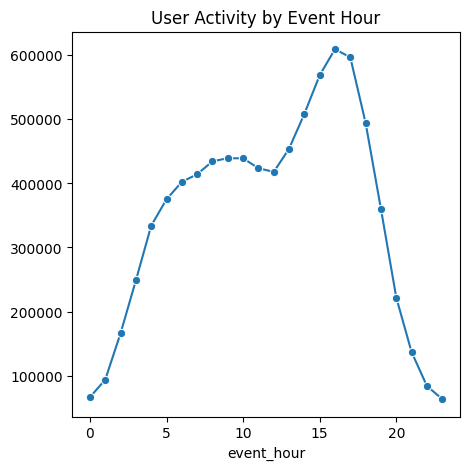

In [71]:
plt.figure(figsize=(5, 5))
sns.lineplot(x=time_df['event_hour'].value_counts().index, y=time_df['event_hour'].value_counts().values, marker='o')
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.title('User Activity by Event Hour')
plt.show()

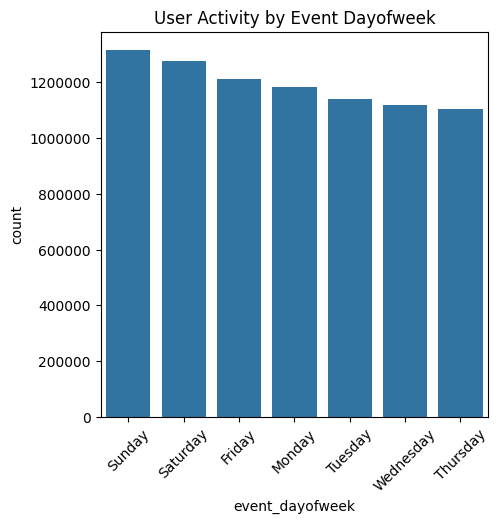

In [72]:
plt.figure(figsize=(5, 5))
sns.countplot(data=time_df, x='event_dayofweek', order=time_df['event_dayofweek'].value_counts().index)
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.xticks(rotation=45)
plt.title('User Activity by Event Dayofweek')
plt.show()

In [92]:
time_df['event_dayofweek'].value_counts()

event_dayofweek
Sunday       1315665
Saturday     1277312
Friday       1210470
Monday       1182194
Tuesday      1141453
Wednesday    1119559
Thursday     1103640
Name: count, dtype: int64

#### event_type 중 cart, purchase 분석

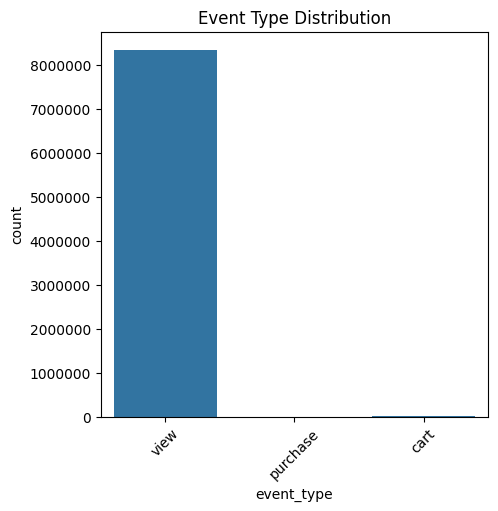

In [7]:
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='event_type')
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.xticks(rotation=45)
plt.title('Event Type Distribution')
plt.show()

In [8]:
df['event_type'].value_counts()

event_type
view        8331867
cart          16350
purchase       2076
Name: count, dtype: int64

In [7]:
cart_purchase_df = df.loc[df['event_type'].isin(['purchase', 'cart'])].copy()
cart_purchase_df['event_time'] = pd.to_datetime(cart_purchase_df['event_time'], format='%Y-%m-%d %H:%M:%S %Z')
cart_purchase_df.drop(columns='brand', inplace=True)
cart_purchase_df.head()

,user_id,item_id,user_session,event_time,category_code,price,event_type
2660,3308e1fb-9ba3-4d5d-b6d7-b69327d1eaf9,f9c5fb98-9577-44a9-b946-d18bc45b8368,8f310373-d270-41b1-8657-17ad43fd44b8,2019-11-13 13:40:01+00:00,apparel.shoes,75.42,purchase
2669,850bb03e-b5d9-4149-bb57-21a842af0585,fb3337d1-220c-4ff6-a8b4-f0c35d0a9e15,8226249b-4a5c-4d2b-9ebc-a681c30ce8af,2019-11-22 12:57:30+00:00,apparel.shoes,89.84,cart
3123,7ab4b640-1d24-4bb3-8c0b-6df2d262ee2c,49ca9039-1e47-4fa5-9757-0e6c5dba2cad,dcb6e447-6186-4994-8f14-a8454290fa08,2019-11-16 15:08:09+00:00,apparel.shoes,85.46,cart
11634,34b8c2ac-4bc9-4446-a73d-93fb03763a1e,81c68118-e936-47a5-a939-7b2a8a780572,be7d4bc4-a409-4b96-abb4-cd3ca97c3bad,2019-11-17 08:46:32+00:00,apparel.shoes,82.63,cart
12859,ff943b26-d621-4ac4-8529-05caf20f8bbf,f01381c1-ce51-4b7a-b24e-62fb6f61dc2f,e994b217-011b-4f19-be67-a9e3d75e1f23,2019-11-16 09:13:21+00:00,apparel.shoes,96.53,cart


In [8]:
# 사용자 상호작용 이상치 날짜에 해당하는 purchase, cart 비율 확인
user_interaction_date_outlier_list = ['2019-11-15', '2019-11-16', '2019-11-17', '2019-12-16', '2019-12-17', '2019-12-18', '2019-12-19', '2020-02-27']
cart_purchase_df.loc[cart_purchase_df['event_time'].dt.date.astype('str').isin(user_interaction_date_outlier_list), 'event_type'].value_counts()
del cart_purchase_df

event_type
purchase    779
cart        571
Name: count, dtype: int64

---

##### purchase

In [60]:
purchase_df = df.loc[df['event_type'].str.contains('purchase')].copy()
purchase_df.drop(columns=['brand', 'event_type'], inplace=True)
purchase_df.head()

,user_id,item_id,user_session,event_time,category_code,price
2660,3308e1fb-9ba3-4d5d-b6d7-b69327d1eaf9,f9c5fb98-9577-44a9-b946-d18bc45b8368,8f310373-d270-41b1-8657-17ad43fd44b8,2019-11-13 13:40:01 UTC,apparel.shoes,75.42
16872,5a9f26f1-972d-4918-b1ee-73df61d495a0,13eebd7f-62c2-4859-8396-5f4c5c92410c,deb74236-4182-48b7-9d01-0fa77f69b4fc,2019-11-16 14:29:53 UTC,apparel.shoes,84.43
35132,174c647c-663d-418a-9f32-223cfe80e823,0dd57aac-9857-4749-b636-61e40132d609,670edfa2-98b0-463e-a553-1e72e6a25537,2019-11-17 10:16:37 UTC,apparel.shoes,82.63
62514,0cd7faa5-eda0-4544-8d7c-4fb43f41eb65,b6a07470-4084-40c3-9349-7e1275cc1150,89df019f-d1b4-43fd-b04f-c3a51ce9bcc4,2019-11-17 06:54:27 UTC,apparel.shoes,71.82
84596,d7fb91c9-b1ad-4224-b109-7c5f3a936715,fb5a01f5-7261-4de0-94d1-9d75d4792185,6167e9f8-5009-4a1a-8789-efe5e29f4431,2019-11-17 05:48:23 UTC,apparel.shoes,86.23


In [61]:
purchase_df.describe(include='all')

,user_id,item_id,user_session,event_time,category_code,price
count,2076,2076,2076,2076,2076,2076.000000
unique,1681,996,1980,2061,24,NaN
top,f3f1f11e-7d61-47b9-a3f2-5320873a2b4d,2e0d2baf-84f8-4609-8411-40106770595a,cdc523c2-494a-4410-921b-2a29d315d193,2020-02-28 06:15:14 UTC,apparel.shoes,NaN
freq,11,188,4,2,723,NaN
mean,NaN,NaN,NaN,NaN,NaN,122.291315
std,NaN,NaN,NaN,NaN,NaN,152.511697
min,NaN,NaN,NaN,NaN,NaN,0.950000
25%,NaN,NaN,NaN,NaN,NaN,30.182500
50%,NaN,NaN,NaN,NaN,NaN,64.240000
75%,NaN,NaN,NaN,NaN,NaN,131.707500


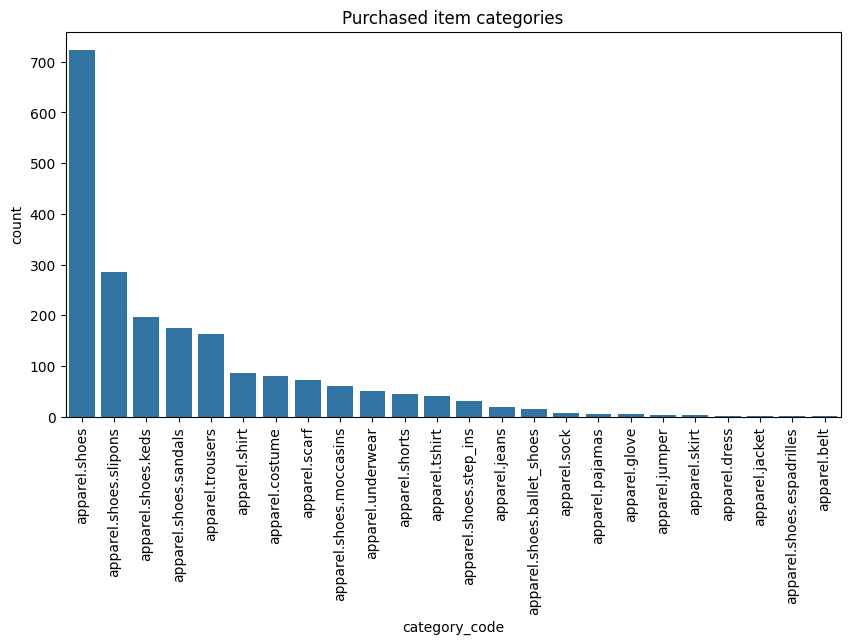

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(data=purchase_df, x='category_code', order=purchase_df['category_code'].value_counts().index)
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.xticks(rotation=90)
plt.title('Purchased item categories')
plt.show()

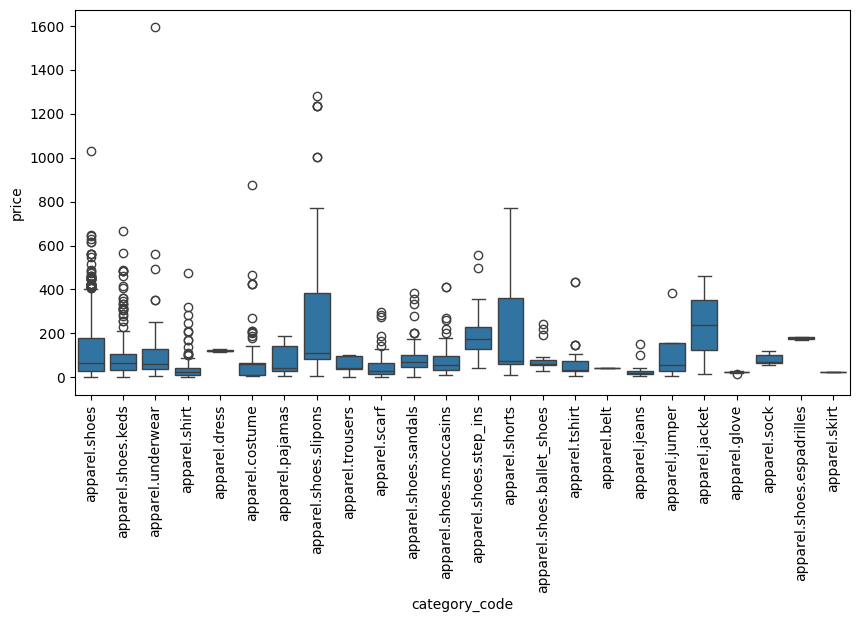

In [ ]:
# 구매 상품 카테고리 별 가격 분포
plt.figure(figsize=(10, 5))
sns.boxplot(data=purchase_df, x='category_code', y='price')
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.xticks(rotation=90)
plt.show()

---

In [84]:
# 구매 빈도가 가장 높은 아이템에 대한 확인
purchase_df.groupby(by='item_id').size().value_counts().sort_index()

1      730
2      119
3       54
4       34
5       13
6        9
7        3
8        9
9        4
10       3
11       4
12       4
15       1
16       1
19       1
21       2
23       1
26       1
50       1
61       1
188      1
Name: count, dtype: int64

<Axes: >

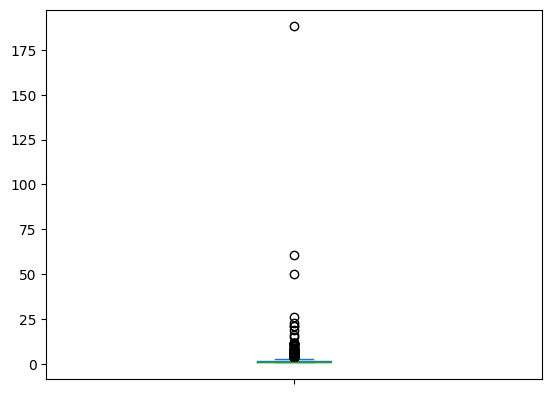

In [89]:
purchase_df.groupby(by='item_id').size().plot(kind='box')

In [90]:
purchase_popular_item_Q3 = purchase_df.groupby(by='item_id').size().quantile(q=0.75)
purchase_popular_item_Q1 = purchase_df.groupby(by='item_id').size().quantile(q=0.25)
purchase_popular_item_IQR = purchase_popular_item_Q3 - purchase_popular_item_Q1
purchase_popular_item_High = purchase_popular_item_Q3 + 1.5 * purchase_popular_item_IQR
print('Purchase price IQR:', purchase_popular_item_IQR)
print('Purchase price High:', purchase_popular_item_High)

Purchase price IQR: 1.0
Purchase price High: 3.5


In [94]:
# 인기있는 구매 아이템
temp_df = purchase_df.groupby(by='item_id').size().reset_index().rename(columns={'item_id':'item_id', 0:'count'})
purchase_popular_item_df = purchase_df.loc[purchase_df['item_id'].isin(temp_df.loc[temp_df['count'] > purchase_popular_item_High, 'item_id'].values)].reset_index(drop=True)
del temp_df
purchase_popular_item_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 946 entries, 0 to 945
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        946 non-null    object 
 1   item_id        946 non-null    object 
 2   user_session   946 non-null    object 
 3   event_time     946 non-null    object 
 4   category_code  946 non-null    object 
 5   price          946 non-null    float64
dtypes: float64(1), object(5)
memory usage: 44.5+ KB


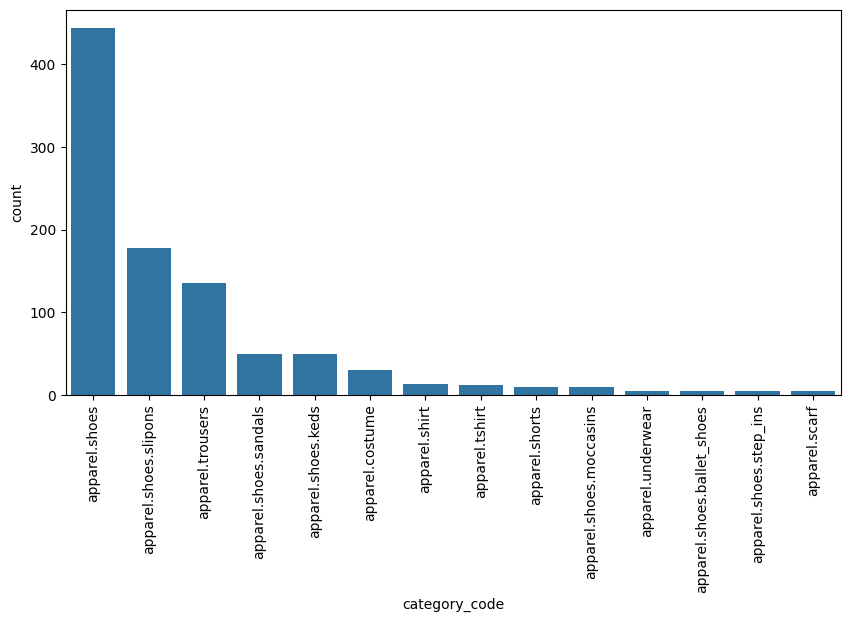

In [95]:
# 인기있는 구매 아이템 카테고리
plt.figure(figsize=(10, 5))
sns.countplot(data=purchase_popular_item_df, x='category_code', order=purchase_popular_item_df['category_code'].value_counts().index)
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.xticks(rotation=90)
plt.show()

In [96]:
# 빈도가 가장 높은 아이템에 대한 확인
pd.pivot_table(data=purchase_popular_item_df.loc[purchase_popular_item_df['item_id'].isin(purchase_popular_item_df['item_id'].value_counts()[:5].index)], index=['item_id', 'category_code'], values='price', aggfunc='mean')

,,price
item_id,category_code,
2e0d2baf-84f8-4609-8411-40106770595a,apparel.shoes,29.959309
c2d911d7-9cb5-4d05-9116-a52a4a4977f1,apparel.shoes,22.410435
d5eec7ed-8259-4f6b-99b0-53250d8a0bd6,apparel.trousers,43.760000
e6503c75-8483-45c3-a1b7-a2631b1e7f3b,apparel.shoes.slipons,110.390385
fb744b46-11e3-4239-bb72-8ece03a1826a,apparel.shoes,389.900000


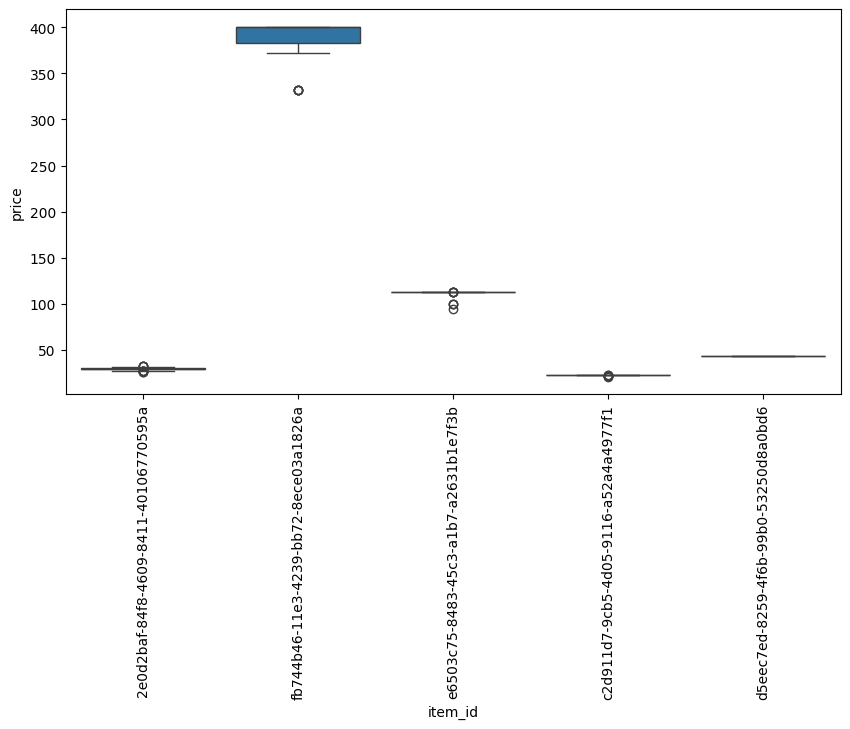

In [98]:
# 빈도가 가장 높은 top 5 아이템에 대한 카테고리 별 가격 분포
plt.figure(figsize=(10, 5))
sns.boxplot(data=purchase_popular_item_df.loc[purchase_popular_item_df['item_id'].isin(purchase_popular_item_df['item_id'].value_counts()[:5].index)], x='item_id', y='price')
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.xticks(rotation=90)
plt.show()

In [146]:
# 빈도가 가장 높은 top 5 아이템에 대한 가격 변동 확인
high_freq_item_dict = {}
for high_freq_item_id in purchase_df['item_id'].value_counts()[:5].index:
    target_item_df = purchase_df.loc[purchase_df['item_id'] == high_freq_item_id]
    min_price = target_item_df['price'].min()
    high_freq_item_dict[high_freq_item_id] = pd.to_datetime(target_item_df.loc[target_item_df['price'] == min_price, 'event_time']).dt.date.unique()
high_freq_item_dict

{'2e0d2baf-84f8-4609-8411-40106770595a': array([datetime.date(2020, 2, 1), datetime.date(2020, 2, 2)], dtype=object),
 'fb744b46-11e3-4239-bb72-8ece03a1826a': array([datetime.date(2019, 12, 22), datetime.date(2019, 12, 26),
        datetime.date(2020, 1, 8), datetime.date(2020, 1, 4)], dtype=object),
 'd5eec7ed-8259-4f6b-99b0-53250d8a0bd6': array([datetime.date(2020, 2, 29), datetime.date(2020, 2, 27),
        datetime.date(2020, 2, 28)], dtype=object),
 'e6503c75-8483-45c3-a1b7-a2631b1e7f3b': array([datetime.date(2019, 12, 23)], dtype=object),
 'c2d911d7-9cb5-4d05-9116-a52a4a4977f1': array([datetime.date(2020, 1, 31)], dtype=object)}

---

In [63]:
# 사용자별 구매횟수 분포 확인
purchase_df.groupby('user_id').size().value_counts()

1     1443
2      164
3       39
4       14
5       13
9        3
8        2
7        1
6        1
11       1
Name: count, dtype: int64

In [102]:
temp_df = purchase_df.groupby('user_id').size().reset_index().rename(columns={'user_id':'user_id', 0:'count'})
purchase_one_more_user_df = purchase_df.loc[purchase_df['user_id'].isin(temp_df.loc[temp_df['count'] > 1, 'user_id'].values)].reset_index(drop=True)
del temp_df
purchase_one_more_user_df.head()

,user_id,item_id,user_session,event_time,category_code,price
0,09f42e30-63e8-4657-953c-f274159a2b88,f24c3aeb-0505-4e88-ac96-e319eca2cd03,e8e13516-1b8c-457e-a74c-0acdb7f73c40,2019-11-16 15:01:58 UTC,apparel.underwear,7.79
1,09f42e30-63e8-4657-953c-f274159a2b88,88695cc8-372b-4f60-ade6-16b0d555e45f,e8e13516-1b8c-457e-a74c-0acdb7f73c40,2019-11-16 15:07:56 UTC,apparel.underwear,7.98
2,7a1788fa-e4fb-46a4-bede-7f5c45e30614,172e8419-3fc3-4e52-9dbe-fae34f6bd1a1,d6598bac-1b6f-4bd6-8631-d79dea6b5e6f,2019-11-16 09:03:28 UTC,apparel.shoes,89.84
3,9807bff8-856c-460f-a934-4a823e6c0178,6e13dbe9-8b77-4040-9a11-e71271ab43ff,0af18ffc-051f-416d-aa27-7c8f08a2dad1,2019-12-29 16:13:36 UTC,apparel.trousers,25.74
4,c7ec8c48-cfb9-4d75-ba1c-d0b1bf799254,8e68a626-93c6-48ac-974d-b07df58464d0,f166bab5-56f1-4e69-95da-4116ebf52f5f,2019-12-29 09:09:49 UTC,apparel.shoes,346.70


In [69]:
# 구매횟수 1을 초과한 사용자 기술통계
purchase_one_more_user_df.describe(include='all')

,user_id,item_id,user_session,event_time,category_code,price
count,633,633,633,633,633,633.000000
unique,238,298,537,627,18,NaN
top,f3f1f11e-7d61-47b9-a3f2-5320873a2b4d,2e0d2baf-84f8-4609-8411-40106770595a,d02f0972-d631-4258-9591-dee4b62d96bd,2020-02-27 16:52:53 UTC,apparel.shoes,NaN
freq,11,54,4,2,205,NaN
mean,NaN,NaN,NaN,NaN,NaN,138.831406
std,NaN,NaN,NaN,NaN,NaN,162.265200
min,NaN,NaN,NaN,NaN,NaN,0.950000
25%,NaN,NaN,NaN,NaN,NaN,30.810000
50%,NaN,NaN,NaN,NaN,NaN,74.250000
75%,NaN,NaN,NaN,NaN,NaN,174.830000


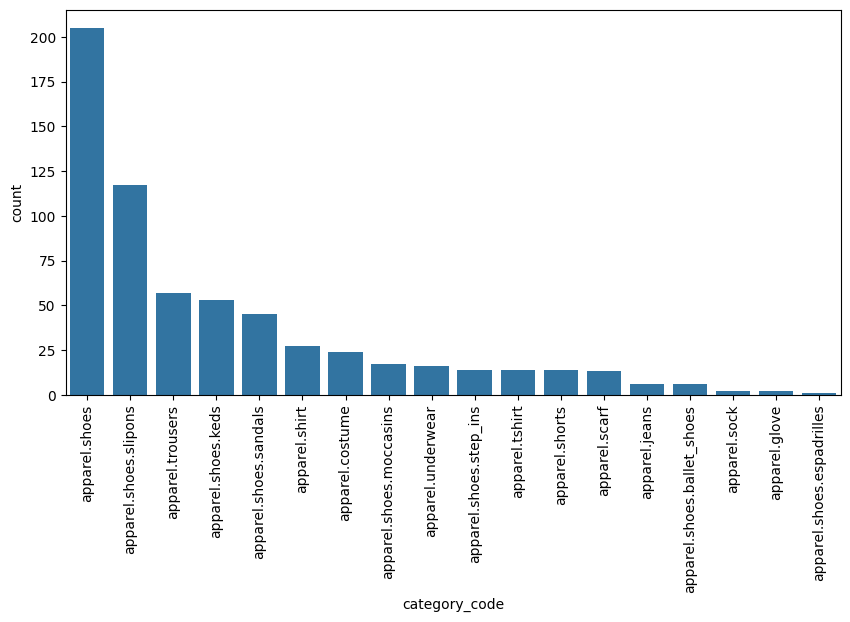

In [73]:
# 두번 이상 구매 이력있는 사용자가 구매한 아이템 카테고리
plt.figure(figsize=(10, 5))
sns.countplot(data=purchase_one_more_user_df, x='category_code', order=purchase_one_more_user_df['category_code'].value_counts().index)
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.xticks(rotation=90)
plt.show()

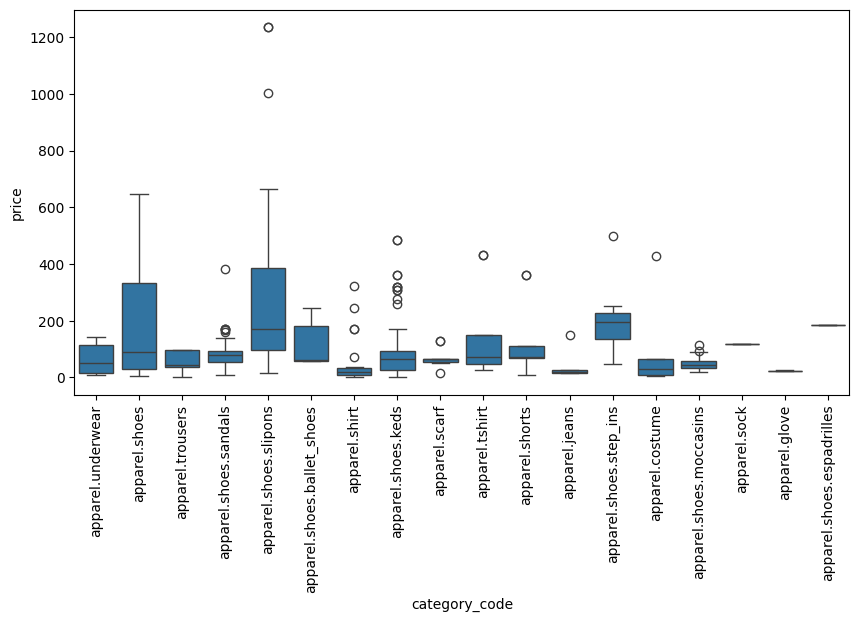

In [75]:
# 두번 이상 구매 이력있는 사용자가 구매한 아이템 카테고리 별 가격
plt.figure(figsize=(10, 5))
sns.boxplot(data=purchase_one_more_user_df, x='category_code', y='price')
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.xticks(rotation=90)
plt.show()

---

In [104]:
# 두번 이상 구매 이력있는 사용자 중 구매한 아이템 빈도수 확인
purchase_one_more_user_df.groupby(by=['user_id', 'item_id']).size().value_counts()

1     299
2      96
3      19
4      12
5       2
8       1
9       1
10      1
Name: count, dtype: int64

In [109]:
# 재구매 아이템
temp_df = purchase_one_more_user_df.groupby(by=['user_id', 'item_id']).size().reset_index().drop(columns='user_id').rename(columns={'item_id':'item_id', 0:'count'})
repurchase_item_df = purchase_one_more_user_df.loc[purchase_one_more_user_df['item_id'].isin(temp_df.loc[temp_df['count'] > 1, 'item_id'].values)].reset_index(drop=True)
del temp_df
repurchase_item_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        408 non-null    object 
 1   item_id        408 non-null    object 
 2   user_session   408 non-null    object 
 3   event_time     408 non-null    object 
 4   category_code  408 non-null    object 
 5   price          408 non-null    float64
dtypes: float64(1), object(5)
memory usage: 19.2+ KB


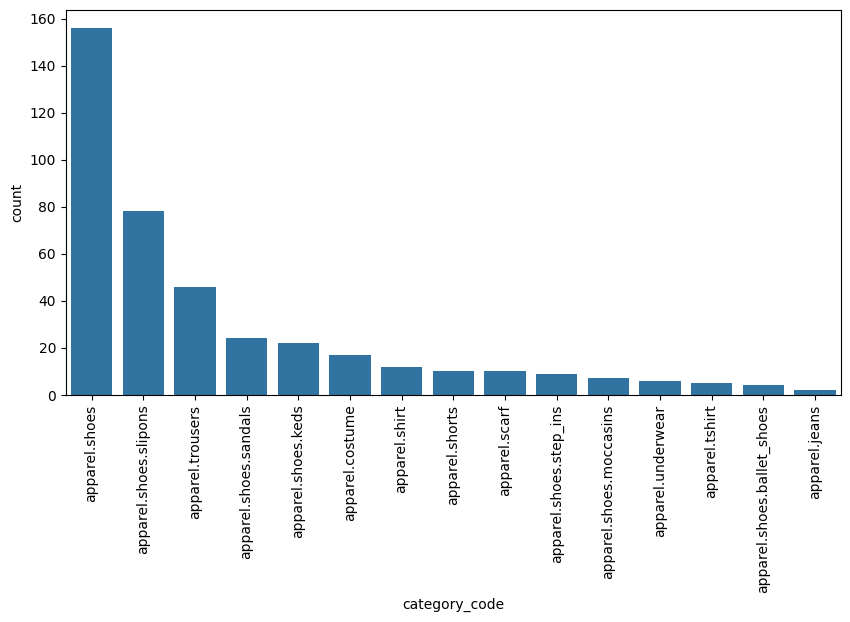

In [110]:
# 재구매 아이템 카테고리
plt.figure(figsize=(10, 5))
sns.countplot(data=repurchase_item_df, x='category_code', order=repurchase_item_df['category_code'].value_counts().index)
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.xticks(rotation=90)
plt.show()

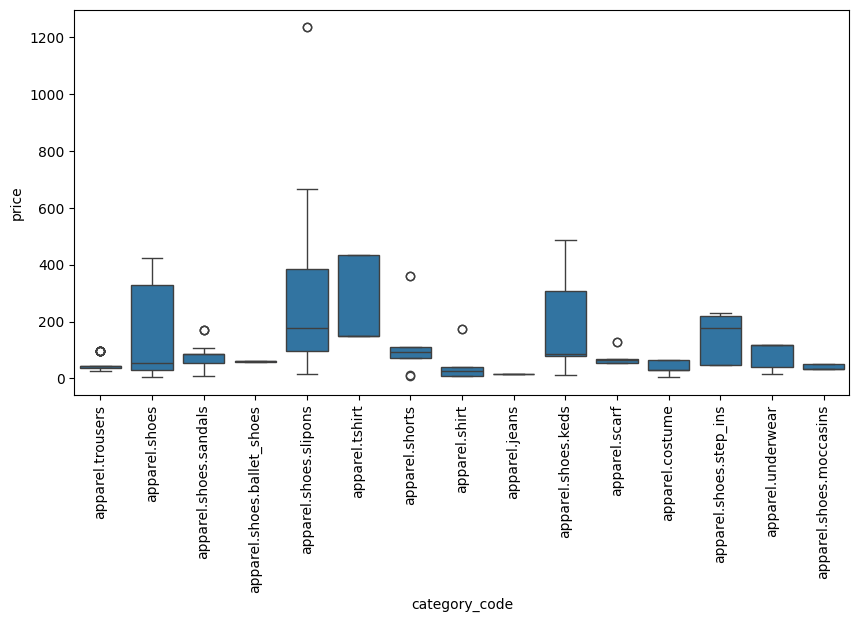

In [111]:
# 재구매 아이템 카테고리 별 가격
plt.figure(figsize=(10, 5))
sns.boxplot(data=repurchase_item_df, x='category_code', y='price')
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.xticks(rotation=90)
plt.show()

---

##### cart

In [67]:
cart_df = df.loc[df['event_type'].str.contains('cart')].copy()
cart_df.drop(columns=['brand', 'event_type'], inplace=True)
cart_df.head()

,user_id,item_id,user_session,event_time,category_code,price
2669,850bb03e-b5d9-4149-bb57-21a842af0585,fb3337d1-220c-4ff6-a8b4-f0c35d0a9e15,8226249b-4a5c-4d2b-9ebc-a681c30ce8af,2019-11-22 12:57:30 UTC,apparel.shoes,89.84
3123,7ab4b640-1d24-4bb3-8c0b-6df2d262ee2c,49ca9039-1e47-4fa5-9757-0e6c5dba2cad,dcb6e447-6186-4994-8f14-a8454290fa08,2019-11-16 15:08:09 UTC,apparel.shoes,85.46
11634,34b8c2ac-4bc9-4446-a73d-93fb03763a1e,81c68118-e936-47a5-a939-7b2a8a780572,be7d4bc4-a409-4b96-abb4-cd3ca97c3bad,2019-11-17 08:46:32 UTC,apparel.shoes,82.63
12859,ff943b26-d621-4ac4-8529-05caf20f8bbf,f01381c1-ce51-4b7a-b24e-62fb6f61dc2f,e994b217-011b-4f19-be67-a9e3d75e1f23,2019-11-16 09:13:21 UTC,apparel.shoes,96.53
14642,2f956138-ceff-4190-9e78-f3d7d75b6323,45ea088d-4170-4449-a176-63ce63dbf243,8fa158cb-6c5e-41ba-a031-1a52c4117ff4,2019-11-14 13:51:50 UTC,apparel.shoes,79.02


In [68]:
cart_df.describe(include='all')

,user_id,item_id,user_session,event_time,category_code,price
count,16350,16350,16350,16350,16350,16350.000000
unique,10481,3854,15695,11450,24,NaN
top,c48f737d-6908-41be-aad3-3a16cbdb7c58,2e0d2baf-84f8-4609-8411-40106770595a,6498a330-2d87-4fc2-8f1c-2347388442db,2020-02-01 10:31:15 UTC,apparel.shoes,NaN
freq,69,2170,8,24,6512,NaN
mean,NaN,NaN,NaN,NaN,NaN,149.463642
std,NaN,NaN,NaN,NaN,NaN,208.884146
min,NaN,NaN,NaN,NaN,NaN,0.770000
25%,NaN,NaN,NaN,NaN,NaN,28.030000
50%,NaN,NaN,NaN,NaN,NaN,65.640000
75%,NaN,NaN,NaN,NaN,NaN,169.370000


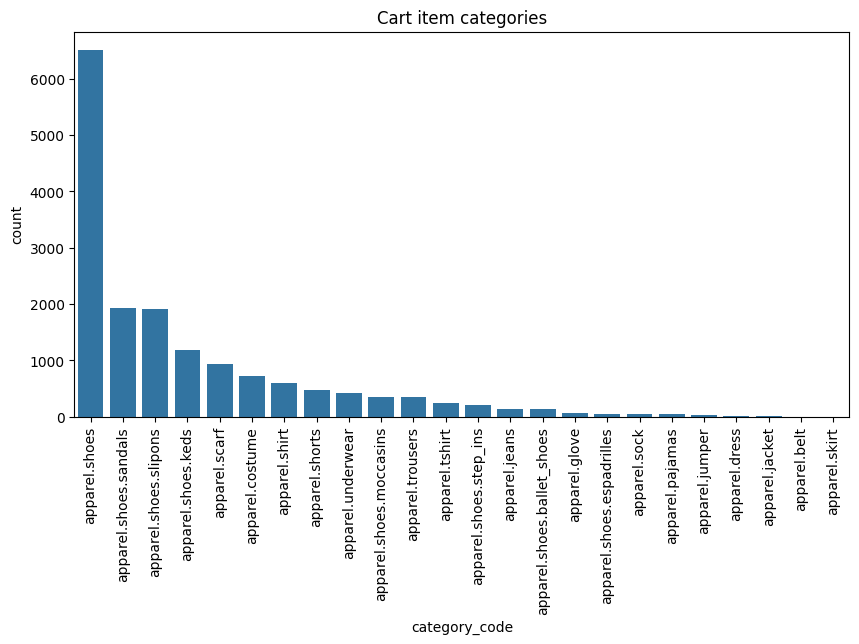

In [59]:
plt.figure(figsize=(10, 5))
sns.countplot(data=cart_df, x='category_code', order=cart_df['category_code'].value_counts().index)
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.xticks(rotation=90)
plt.title('Cart item categories')
plt.show()

In [125]:
# 빈도가 가장 높은 아이템에 대한 가격 변동 확인
cart_df.loc[cart_df['item_id'] == '2e0d2baf-84f8-4609-8411-40106770595a']

,user_id,item_id,user_session,event_time,category_code,price
1232276,c3e9dbda-ee42-436e-b7ce-40e0ed27421c,2e0d2baf-84f8-4609-8411-40106770595a,66d8b629-0475-416a-9e7d-4fda4b4c660b,2019-12-30 11:16:33+00:00,apparel.shoes,29.99
1261221,6449093f-f84d-48f8-9116-ae0e441cfe6e,2e0d2baf-84f8-4609-8411-40106770595a,3e5333a3-300f-4dbf-95ca-13b83f35c85b,2019-12-17 12:26:04+00:00,apparel.shoes,29.65
1321328,1971aed8-4237-40a7-b4b1-8cabb3dd5663,2e0d2baf-84f8-4609-8411-40106770595a,f3b37948-0da2-4d7f-873a-675653ed9f02,2019-12-27 18:46:06+00:00,apparel.shoes,30.19
1329057,336e5379-b460-4c68-8d79-4a58a1ac7d05,2e0d2baf-84f8-4609-8411-40106770595a,06e2b64c-02aa-4847-ae2f-b03b03153624,2019-12-08 15:08:21+00:00,apparel.shoes,29.86
1334945,74684b94-5900-4a99-84b8-ffc0b87d5c8a,2e0d2baf-84f8-4609-8411-40106770595a,30c43560-2e3d-4655-b98e-0e592f8a2d88,2019-12-23 16:25:26+00:00,apparel.shoes,30.68
...,...,...,...,...,...,...
8344853,ec646f78-1132-4ac3-9a87-d5f6aaa6cd71,2e0d2baf-84f8-4609-8411-40106770595a,faf950d6-357c-454b-abdc-aba79bc00a63,2020-02-05 18:22:32+00:00,apparel.shoes,28.81
8344904,6cb9afa6-d6c4-4e4a-9ac6-c4d3ff3f3b44,2e0d2baf-84f8-4609-8411-40106770595a,fee6aa8c-2fb0-43d9-b9f9-bed8d029db37,2020-02-09 05:44:50+00:00,apparel.shoes,28.75
8345182,778d7db2-e24b-4930-9928-35a0c8ca278b,2e0d2baf-84f8-4609-8411-40106770595a,1604dbf1-b037-4dbb-a7dc-f078066f849a,2020-02-02 18:09:08+00:00,apparel.shoes,27.49
8349879,28c564d5-299a-47ab-bf9b-e4a66c12e7f7,2e0d2baf-84f8-4609-8411-40106770595a,43dfc0fe-f3d5-4ce5-ac24-7dc4d03edbfc,2020-02-24 11:12:38+00:00,apparel.shoes,31.89


In [126]:
# 빈도가 가장 높은 아이템에 대한 가격 변동 확인
cart_df.loc[cart_df['item_id'] == '2e0d2baf-84f8-4609-8411-40106770595a', 'price'].describe()

count    2170.000000
mean       27.671834
std         1.501285
min        26.230000
25%        26.720000
50%        26.720000
75%        28.750000
max        33.330000
Name: price, dtype: float64

In [128]:
# 빈도가 가장 높은 아이템에 대한 가격 변동 확인
cart_df.loc[(cart_df['item_id'] == '2e0d2baf-84f8-4609-8411-40106770595a') & (cart_df['price'] == 26.23)]

,user_id,item_id,user_session,event_time,category_code,price
6484944,eed63e8f-be3b-43a7-80c5-a533fadcfee7,2e0d2baf-84f8-4609-8411-40106770595a,c65290d1-07c0-4b93-9dfe-cb65b357b579,2020-02-01 14:37:50+00:00,apparel.shoes,26.23
6493609,4d08c036-2bc4-4fb5-9ffa-44964cddb128,2e0d2baf-84f8-4609-8411-40106770595a,e386994d-fb4b-4780-a505-1df9d47a36b4,2020-02-01 12:56:04+00:00,apparel.shoes,26.23
6497707,2b3cb7d3-4969-4928-93cf-9ac8bc0f198e,2e0d2baf-84f8-4609-8411-40106770595a,44a94dac-5083-4007-9e89-04f6d8829f5a,2020-02-01 15:43:53+00:00,apparel.shoes,26.23
6498596,98e176e5-4a76-4254-999f-f6eaf8e61d90,2e0d2baf-84f8-4609-8411-40106770595a,3561bb50-cb9b-4185-9b34-e7be4f589a91,2020-02-02 02:01:26+00:00,apparel.shoes,26.23
6502103,1b6a526a-85fe-407f-b030-787d246c3cab,2e0d2baf-84f8-4609-8411-40106770595a,812351f7-9020-469c-9813-dc7ace50a494,2020-02-01 17:29:13+00:00,apparel.shoes,26.23
...,...,...,...,...,...,...
8282582,0f8eb8c2-db5a-4710-a689-fda3d21c3f89,2e0d2baf-84f8-4609-8411-40106770595a,061130dd-0a52-4fd7-a1cc-4a4125255629,2020-02-01 11:50:11+00:00,apparel.shoes,26.23
8296465,69d1283e-2766-4d70-a441-710025ecc0fb,2e0d2baf-84f8-4609-8411-40106770595a,bb8cba4c-c44f-4b53-a304-9e6f9335fac1,2020-02-01 17:35:40+00:00,apparel.shoes,26.23
8301439,09fc98f0-e0b4-449a-86fa-25145d1b6057,2e0d2baf-84f8-4609-8411-40106770595a,ae66794f-bc51-450a-8de0-dd5e46a47c4d,2020-02-02 07:04:41+00:00,apparel.shoes,26.23
8302696,8096cfe5-46c8-493e-a841-d724156119c3,2e0d2baf-84f8-4609-8411-40106770595a,4fea3bdf-b689-4cd3-ab7f-ef81eddc9b8c,2020-02-02 06:26:12+00:00,apparel.shoes,26.23


In [130]:
# 빈도가 가장 높은 아이템에 대한 가격 변동 확인
cart_df.loc[(cart_df['item_id'] == '2e0d2baf-84f8-4609-8411-40106770595a') & (cart_df['price'] == 26.23), 'event_time'].dt.date.value_counts()

event_time
2020-02-01    145
2020-02-02     46
Name: count, dtype: int64

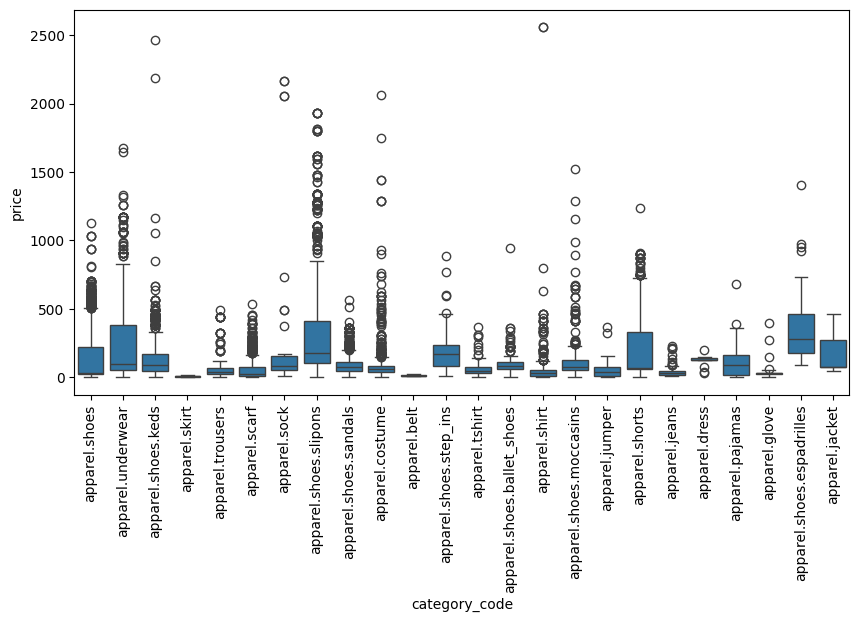

In [131]:
# 구매 상품 카테고리 별 가격 분포
plt.figure(figsize=(10, 5))
sns.boxplot(data=cart_df, x='category_code', y='price')
plt.ticklabel_format(axis='y',useOffset=False, style='plain')
plt.xticks(rotation=90)
plt.show()

---

### Feature Engineering

1. category_code에서 apparel 제거 처리
2. event_time > date, hour, dayofweek 추출
3. brand 제거

In [ ]:
# 모든 상품의 대분류가 'apparel'로 시작하므로 실질적인 중분류로 확인할 수 있도록 수정 
df['category_code'] = df['category_code'].str.replace('apparel.', '')
df.head()

In [ ]:
df['event_time'] = pd.to_datetime(df['event_time'], format='%Y-%m-%d %H:%M:%S %Z')
df['event_date'] = df['event_time'].dt.date
df['event_hour'] = df['event_time'].dt.hour
# 요일 - 월요일(0), 화요일(1), 수요일(2), 목요일(3), 금요일(4), 토요일(5), 일요일(6)
df['event_dayofweek'] = df['event_time'].dt.dayofweek
df.drop(columns='event_time', inplace=True)
df.head()

In [ ]:
df.drop(columns='brand', inplace=True)
df.head()